# Homework 1

## General procedures

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.datasets import make_blobs
from sklearn.metrics.pairwise import euclidean_distances
import time
from imblearn.under_sampling import RandomUnderSampler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import precision_recall_curve, auc

In [2]:
# Definition of the parameters.
 
# In this case n = number of samples 
# The dimension of the optimization problem is equal to the number of (unlabeled) examples. 
# The problem is optimized  with respect to the correctness of the y_u labeling 
nSamples = 10**3
percentageUnlabeled = 0.99
tolerance = 10**-2
maxIterations = 50000
maxTime = 200

# Strings to identify the methods as they are used repeatedly in the implementation
stringGM = 'Gradient method'
stringBCGD_rnd = 'Randomized BCGD'
stringBCGD_GS = 'Gauss-Southwell BCGD'
stringFixed = 'Fixed alpha'
stringExact = 'Exact alpha'

# Other useful variables. The seed for the simulated data and the starting point of the algorithms and a dictionary to store the results
seed = 111
resultsSD = {}
resultsRD = {}

In [3]:
# Defining a function to plot the variables
def plot_classes(X_l, y_l, X_u, y_u, method):
      
    # Plotting the originally unlabeled data. It could be the original problem (no labels) or the predicted labels
    if method == 'Initial problem':
        plt.plot(X_u[:,0], X_u[:,1], 'k.', label='Unlabeled examples')
        plt.title(method)
    else:
        y_u = np.sign(y_u)
        plt.plot(X_u[y_u == 1, 0], X_u[y_u == 1, 1], 'cx', label='Predicted y=1')
        plt.plot(X_u[y_u == -1, 0], X_u[y_u == -1, 1], 'mx', label='Predicted y=-1')
        plt.title(f'Predicted labels: {method}')
    
    # Plotting the original labeled data
    plt.plot(X_l[y_l == 1, 0], X_l[y_l == 1, 1], 'y.', label='True y=1')
    plt.plot(X_l[y_l == -1, 0], X_l[y_l == -1, 1], 'r.', label='True y=-1')

    plt.xlabel("X1")
    plt.ylabel("X2")
    
    plt.legend()


X_labeled shape: (10, 2), y_labeled shape: (10,)
X_unlabeled shape: (990, 2), y_unlabeled shape: (990,)
Length of class y_labeled=1: 4
Length of class y_labeled=-1: 6


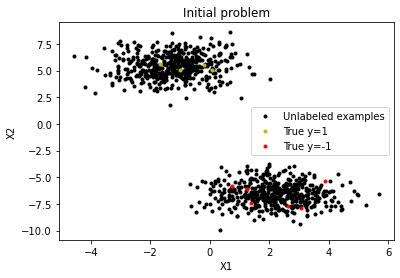

In [4]:
# Generation of the points in 2D with two classes
def data_generation():
    X, y = make_blobs(n_samples=nSamples, n_features=2, centers=2, random_state=seed, 
                      cluster_std=1.05)

    # Relabeling from 0 to -1 and  
    y[y==0] = -1

    # Setting most of the labels to a 'null' identifier
    np.random.seed(seed)
    indices = np.random.choice(range(len(y)), size=int(percentageUnlabeled*len(y)), replace=False)
    nullIdentifier = 99
    y[indices] = nullIdentifier
    
    # Splitting the data into labeled and unlabeled
    y_l, X_l = y[y!=nullIdentifier], X[y!=nullIdentifier]
    y_u, X_u = y[y==nullIdentifier], X[y==nullIdentifier]
    
    # Checking the size of the matrices and vectors
    print(f'X_labeled shape: {X_l.shape}, y_labeled shape: {y_l.shape}')
    print(f'X_unlabeled shape: {X_u.shape}, y_unlabeled shape: {y_u.shape}')
    
    # Checking the size of each labeled class
    print(f'Length of class y_labeled=1: {len(y_l[y_l==1])}')
    print(f'Length of class y_labeled=-1: {len(y_l[y_l==-1])}')
    
    return X_l, y_l, X_u
XLabeled, yLabeled, XUnlabeled  = data_generation()


# Plot for the classes (the ones with the label are highlithed with colors)
plot_classes(X_l=XLabeled, y_l=yLabeled, X_u=XUnlabeled, y_u=None, method='Initial problem')

In [5]:
# Implementing the similarity measures
def similarity_measures(epsilon, X_l, X_u):
    eps = epsilon
    w = np.exp((-euclidean_distances(X_l,X_u)**2)/(eps**2))
    w_bar = np.exp((-euclidean_distances(X_u,X_u)**2)/(eps**2))

    print(f'W shape: {w.shape}')
    print(f'W_bar shape: {w_bar.shape}')
    return w, w_bar
w, w_bar = similarity_measures(epsilon=1, X_l=XLabeled, X_u=XUnlabeled)

W shape: (10, 990)
W_bar shape: (990, 990)


In [6]:
# Definition and execution of some of the problem characteristics: the objective function, the gradient function and the Hessian

# Definition of the cost (objective) function
def cost_function(y_u, y_l, w, w_bar):
    first_term = 0
    for i in range(len(y_l)):
        for j in range(len(y_u)):
            first_term += w[i,j]*(y_u[j]-y_l[i])**2
    
    second_term = 0
    for i in range(len(y_u)):
        for j in range(len(y_u)):
            second_term += w_bar[i,j]*(y_u[i]-y_u[j])**2
    return first_term + 0.5*second_term

#---------------------------------------------------------
# Definition of the gradient function with respect to the y_u jth component 
def gradient_yj(j, y_u, y_l, w, w_bar):
    first_term = 0
    for i in range(len(y_l)):
        first_term += w[i,j]*(y_u[j]-y_l[i])
    
    second_term = 0
    for i in range(len(y_u)):
        second_term += w_bar[i,j]*(y_u[j]-y_u[i])
    return 2*first_term + 2*second_term

#---------------------------------------------------------
# Definition of the complete Hessian matrix
def hessian_matrix(X_u, w, w_bar):
    
    # Definition of the hessian function with respect to the y_u jth component
    def hessian_yj(j, w, w_bar):
        first_term = 0
        for i in range(len(w)):
            first_term += w[i,j]

        second_term = 0
        for i in range(len(w_bar)):
            second_term += w_bar[i,j]

        third_term = w_bar[j,j]
        return 2*first_term + 2*second_term - 2*third_term
    
    # Definition of the hessian function with respect to the y_u ith component
    def hessian_yi(i, j, w_bar):
        return -2*w_bar[i,j]

    
    # Calculation of the upper part of the matrix (since it is symmetric, only one half needs to be calculated and the other hald can be copied)
    hessian = np.zeros((len(X_u), len(X_u)))
    for i in range(hessian.shape[0]):
        for j in range(hessian.shape[1]):
            if i == j:
                hessian[i,j] = hessian_yj(j, w, w_bar)
            elif j > i:
                hessian[i,j] = hessian_yi(i, j, w_bar)         
    hessian = np.triu(hessian) + np.triu(hessian, 1).T
    
    return hessian

# Definition of the function to compute the Lipschitz constat after checking if the matrix is positive definite
def lipschitz_constant(hessian):
    eigenValues = np.linalg.eigvals(hessian)
    if all(eigenValues) > 0:
        L = max(eigenValues)
        print(f'Hessian is positive definite with L = {L:.2f}')
    else:
        L = np.nan
        print('Hessian is NOT positive definite')
    return L
        
# Definition of the funciton to calculate the step size
def step_size(alpha_type, hessian, j=None):
    # If it is fixed, the step size is the same for all methods
    if alpha_type == stringFixed:
        alpha = 1/lipschitz_constant(hessian)
    elif alpha_type == stringExact:
    # The exact line search is implemented only for the BCGD methods and it is the same in both cases
        alpha = 1/hessian[j,j]
    return alpha

#---------------------------------------------------------
# Execution of the Hessian matrix
hessianMatrix = hessian_matrix(X_u=XUnlabeled, w=w, w_bar=w_bar)

# Computation of the Lipschitz constat after checking if the matrix is positive definite
L = lipschitz_constant(hessianMatrix)

Hessian is positive definite with L = 330.88


## Gradient method

Hessian is positive definite with L = 330.88


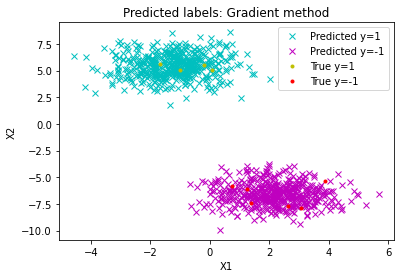

In [7]:
# Defining the function for the gradient method
def gradient_method(length_y_u, y_l, w, w_bar, max_iter, max_time, hessian, resultsDict):
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gradientNormList = []
    startTime = time.time()
    timeSpent=0
    
    iterations = 0
    gradient = np.full(length_y_u, np.nan)
    gradientNorm = 999
    
    # Selection of the starting point at random
    np.random.seed(seed)
    y_u = np.random.choice([-1,1],size=length_y_u)
    
    # Calculation of the step size. For the gradient method, only the fixed step size is implemented
    alpha = step_size(alpha_type=stringFixed, hessian=hessian)  
    
    # Iterating until optimality conditions are met
    while(gradientNorm > tolerance and iterations <= max_iter and timeSpent < max_time):
        # Calculation of the whole gradient
        for j in range(length_y_u):
            gradient[j] = gradient_yj(j, y_u, y_l, w, w_bar)
        
        # Update of the y_u vector
        y_u = y_u - alpha*gradient
        
        # Update of the optimality conditions
        gradientNorm = np.linalg.norm(gradient)
        iterations += 1
        
        # Append of the time, the iterations and the gradient norm (the error)
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gradientNormList.append(gradientNorm)
        
    resultsDict[stringGM] = [timeList, iterationsList, gradientNormList, y_u]
    return y_u, gradientNorm,iterations

# Executing the gradient method
yPredGM, gradientNormGM,iterationsGM = gradient_method(length_y_u=len(XUnlabeled), y_l=yLabeled, w=w, w_bar=w_bar, 
                                                       max_iter=maxIterations, max_time=maxTime, hessian=hessianMatrix, 
                                                       resultsDict=resultsSD)

# Plot for the classes (the predictions have 'x' as markers with the corresponding predicted class color)
plot_classes(X_l=XLabeled, y_l=yLabeled, X_u=XUnlabeled, y_u=yPredGM, method=stringGM)

## Randomized BCGD method

Hessian is positive definite with L = 330.88


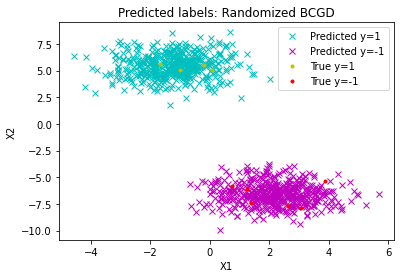

In [8]:
# Defining the function for the randomized BCGD method
def randomized_bcgd(length_y_u, y_l, w, w_bar, alpha_type, max_iter, max_time, hessian, resultsDict):
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gradientNormList = []
    startTime = time.time()
    timeSpent=0
    
    iterations = 0
    U = np.identity(length_y_u)
    
    # Selection of the starting point at random
    np.random.seed(seed)
    y_u = np.random.choice([-1,1],size=length_y_u)
    
    # Calculation of the whole gradient only for the first time, for the subsequent iterations the gradient is only computed for a random block
    gradient = np.full(length_y_u, np.nan)
    for j in range(length_y_u):
        gradient[j] = gradient_yj(j, y_u, y_l, w, w_bar)
    gradientNorm = np.linalg.norm(gradient)
    
    # Calculation of the step size in case that the fixed step size was chosen
    if alpha_type == stringFixed:
        alpha = step_size(alpha_type=alpha_type, hessian=hessian)
    
    # Iterating until optimality conditions are met
    while(gradientNorm > tolerance and iterations <= max_iter and timeSpent < max_time):
        # Selecting a block (index) at random with uniform probability
        j = np.random.choice(range(length_y_u), size=1, replace=True).item()
        
        # Update of the jth component of the gradient (the one that was randomly picked)
        gradient[j] = gradient_yj(j, y_u, y_l, w, w_bar)
        
        # Calculation of the step size in case that the exact line search was chosen
        if alpha_type == stringExact:
            alpha = step_size(alpha_type=alpha_type, j=j, hessian=hessian)
            
        # Update of the y_u vector
        y_u = y_u - alpha*U[:,j]*gradient[j].item()
        
        # Update of the optimality conditions
        gradientNorm = np.linalg.norm(gradient)
        iterations += 1
        
        # Append of the time, the iterations and the gradient norm (the error)
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gradientNormList.append(gradientNorm)
    resultsDict['-'.join([stringBCGD_rnd, alpha_type])] = [timeList, iterationsList, gradientNormList, y_u]
    return y_u, gradientNorm,iterations

# Executing the randomized BCGD method (with both step sizes)
yPredBCGD_rnd_fix, gradientNormBCGD_rnd_fix, iterationsBCGD_rnd_fix = randomized_bcgd(length_y_u=len(XUnlabeled), y_l=yLabeled, w=w, w_bar=w_bar, 
                                                                                      alpha_type = stringFixed, max_iter=maxIterations, max_time=maxTime,
                                                                                      hessian=hessianMatrix, resultsDict=resultsSD)
yPredBCGD_rnd_ex, gradientNormBCGD_rnd_ex, iterationsBCGD_rnd_ex = randomized_bcgd(length_y_u=len(XUnlabeled), y_l=yLabeled, w=w, w_bar=w_bar, 
                                                                                   alpha_type = stringExact, max_iter=maxIterations, max_time=maxTime,
                                                                                   hessian=hessianMatrix, resultsDict=resultsSD)

# Plot for the classes (the predictions have 'x' as markers with the corresponding predicted class color)
plot_classes(X_l=XLabeled, y_l=yLabeled, X_u=XUnlabeled, y_u=yPredBCGD_rnd_ex, method=stringBCGD_rnd)

## Gauss-Southwell BCGD method

Hessian is positive definite with L = 330.88


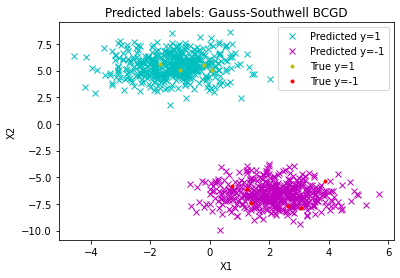

In [9]:
# Defining the function for the Gauss-Southwell BCGD method
def gauss_southwell_bcgd(length_y_u, y_l, w, w_bar, alpha_type, max_iter, max_time, hessian, resultsDict):
    # Initilization of the variables
    timeList = [] 
    iterationsList = []
    gradientNormList = []
    startTime = time.time()
    timeSpent=0
    
    iterations = 0
    U = np.identity(length_y_u)
    
    # Selection of the starting point at random
    np.random.seed(seed)
    y_u = np.random.choice([-1,1],size=length_y_u)
    
    # Calculation of the whole gradient only for the first time, for the subsequent iterations an incremental update is implemented
    gradient = np.full(length_y_u, np.nan)
    for j in range(length_y_u):
        gradient[j] = gradient_yj(j, y_u, y_l, w, w_bar)
    gradientNorm = np.linalg.norm(gradient)
    
    # Calculation of the step size in case that the fixed step size was chosen
    if alpha_type == stringFixed:
        alpha = step_size(alpha_type=alpha_type, hessian=hessian)
    
    # Iterating until optimality conditions are met
    while(gradientNorm > tolerance and iterations <= max_iter and timeSpent < max_time):
        # Selecting the block (index) which corresponds to the block gradient with the maximum norm
        j = np.argmax(np.abs(gradient))
        
        # Calculation of the step size in case that the exact line search was chosen
        if alpha_type == stringExact:
            alpha = step_size(alpha_type=alpha_type, j=j, hessian=hessian)
        
        # Update of the y_u vector
        y_u = y_u - alpha*U[:,j]*gradient[j].item()
        
        # Incremental update of the gradient for the iteration k+1 taking advantage of the one-dimensional block
        gradient = gradient - alpha*hessian[:,j]*gradient[j]
        
        # Update of the optimality conditions (only starts calculating the real norm when the gradient is complete)
        gradientNorm = np.linalg.norm(gradient)
        iterations += 1
        
        # Append of the time, the iterations and the gradient norm (the error)
        currentTime = time.time()
        timeSpent = currentTime-startTime
        timeList.append(timeSpent)
        iterationsList.append(iterations)
        gradientNormList.append(gradientNorm)
        
    resultsDict['-'.join([stringBCGD_GS,alpha_type])] = [timeList, iterationsList, gradientNormList, y_u]
    return y_u, gradientNorm,iterations

# Executing the Gauss-Southwell BCGD method
yPredBCGD_GS_fix, gradientNormBCGD_GS_fix, iterationsBCGD_GS_fix = gauss_southwell_bcgd(length_y_u=len(XUnlabeled), y_l=yLabeled, w=w, w_bar=w_bar, 
                                                                                        alpha_type=stringFixed, max_iter=maxIterations, max_time=maxTime, 
                                                                                        hessian=hessianMatrix, resultsDict=resultsSD)
yPredBCGD_GS_ex, gradientNormBCGD_GS_ex, iterationsBCGD_GS_ex = gauss_southwell_bcgd(length_y_u=len(XUnlabeled), y_l=yLabeled, w=w, w_bar=w_bar, 
                                                                                     alpha_type=stringExact, max_iter=maxIterations, max_time=maxTime,
                                                                                     hessian=hessianMatrix, resultsDict=resultsSD)


# Plot for the classes (the predictions have 'x' as markers with the corresponding predicted class color)
plot_classes(X_l=XLabeled, y_l=yLabeled, X_u=XUnlabeled, y_u=yPredBCGD_GS_ex, method=stringBCGD_GS)

## Accuracy results (synthetic data)

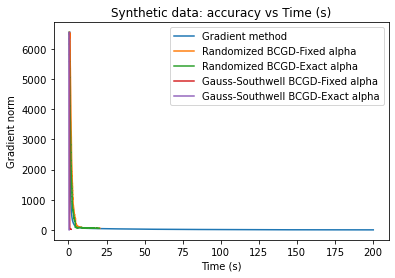

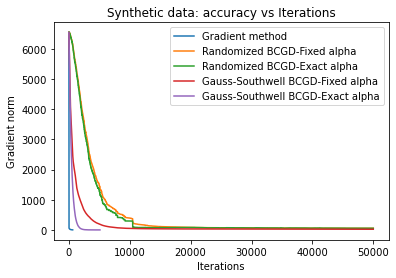

In [10]:
# Definition of the function to plot the accuracy
def plot_accuracy(plot_type, resultsDict, problem_type):
    # Create a figure and axis object
    fig, ax = plt.subplots()
    if plot_type == 'Time (s)':
        for method, result in resultsDict.items():
            x = result[0]
            y = result[2]
            ax.plot(x, y, label=method)
            
        # Truncation of the plots for a better visualization
        #plt.xlim(0, 60)
    elif plot_type == 'Iterations':
        for method, result in resultsDict.items():
            x = result[1]
            y = result[2]
            ax.plot(x, y, label=method)
            
        # Truncation of the plots for a better visualization
        if problem_type == 'Real data':
            plt.xlim(0, 200000)
    
    
    ax.set_title(f'{problem_type}: accuracy vs {plot_type}')
    ax.set_xlabel(plot_type)
    ax.set_ylabel('Gradient norm')
    ax.legend()
    
plot_accuracy('Time (s)', resultsDict=resultsSD, problem_type='Synthetic data')
plot_accuracy('Iterations', resultsDict=resultsSD, problem_type='Synthetic data')

In [11]:
# Calculation of the objective function using the resulting y_u for each method
def print_objective_function(resultsDict):
    for method, result in resultsDict.items():
        print(f'The resulting objective function for the {method} method is {cost_function(y_u=result[3], y_l=yLabeled, w=w, w_bar=w_bar):}')
print_objective_function(resultsDict=resultsSD)

The resulting objective function for the Gradient method method is 0.719107004823369
The resulting objective function for the Randomized BCGD-Fixed alpha method is 492.6175240203745
The resulting objective function for the Randomized BCGD-Exact alpha method is 299.413138812872
The resulting objective function for the Gauss-Southwell BCGD-Fixed alpha method is 120.0259209237288
The resulting objective function for the Gauss-Southwell BCGD-Exact alpha method is 3.8322103126851807e-07


## Testing with real data

In [12]:
# Reading and preparing the data from fraudulent credit cards

percentageUnlabeledRD = 0.9
creditCardFile = pd.read_csv(r'.\creditcard.csv')

In [13]:
# Function to process the data to be suitable to be used in the semi-supervised learning problem
def data_processing():
    
    # Changing the class label corresponding to not fraudulent
    creditCardFile.loc[creditCardFile['Class']==0,'Class']=-1
    
    # Preparing the format of the data
    y_RD = creditCardFile['Class'].to_numpy()
    X_RD = creditCardFile[['V1','V2']].to_numpy()
    
    # Since there is a great unbalance, the majority class is undersampled
    undersampler = RandomUnderSampler(random_state = seed, sampling_strategy=0.2)
    X_RD, y_RD = undersampler.fit_resample(X_RD, y_RD)
    
    unique_vals, counts = np.unique(y_RD, return_counts=True)
    
    print(X_RD.shape)
    print(y_RD.shape)
    print(f'The labels are {unique_vals} and the counts are {counts}')
    
    # Setting most of the labels to a 'null' identifier (the original vector is saved for a later comparison)
    y_Original_RD = y_RD.copy()
    np.random.seed(seed)
    indices = np.random.choice(range(len(y_RD)), size=int(percentageUnlabeled*len(y_RD)), replace=False)
    
    # The copy of the original are saved as true values to compare with the resulting unlabeled examples in the end
    y_true_RD = y_RD[indices].copy()
    nullIdentifier = 99
    y_RD[indices] = nullIdentifier
    
    # Splitting the data into labeled and unlabeled
    y_l, X_l = y_RD[y_RD!=nullIdentifier], X_RD[y_RD!=nullIdentifier]
    y_u, X_u = y_RD[y_RD==nullIdentifier], X_RD[y_RD==nullIdentifier]
    
    # Checking the size of the matrices and vectors
    print(f'X_labeled shape: {X_l.shape}, y_labeled shape: {y_l.shape}')
    print(f'X_unlabeled shape: {X_u.shape}, y_unlabeled shape: {y_u.shape}')
    
    # Checking the size of each labeled class
    print(f'Length of class y_labeled=1: {len(y_l[y_l==1])}')
    print(f'Length of class y_labeled=-1: {len(y_l[y_l==-1])}')
    
    return X_l, y_l, X_u, y_true_RD
XLabeledRD, yLabeledRD, XUnlabeledRD, yTrueRD = data_processing()

(2952, 2)
(2952,)
The labels are [-1  1] and the counts are [2460  492]
X_labeled shape: (30, 2), y_labeled shape: (30,)
X_unlabeled shape: (2922, 2), y_unlabeled shape: (2922,)
Length of class y_labeled=1: 5
Length of class y_labeled=-1: 25


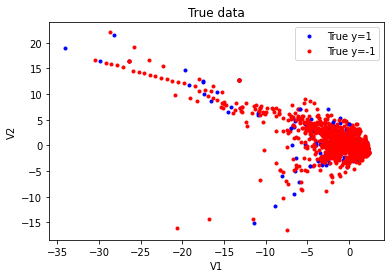

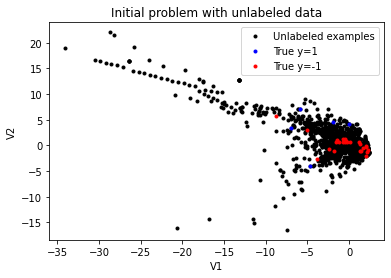

In [20]:
# Plots of the initial problem
def plot_classesRD(X_l, y_l, X_u, y_u, method):
    
    fig, ax = plt.subplots()
    
    # Plotting the originally unlabeled data. It could be the original problem (no labels) or the predicted labels
    if method == 'Initial problem with unlabeled data':
        ax.plot(X_u[:,0], X_u[:,1], 'k.', label='Unlabeled examples')
        plt.title(method)
    elif method == 'True data':
        y_u = np.sign(y_u)
        ax.plot(X_u[y_u == 1, 0], X_u[y_u == 1, 1], 'b.')
        ax.plot(X_u[y_u == -1, 0], X_u[y_u == -1, 1], 'r.')
        plt.title(method)
    else:
        y_u = np.sign(y_u)
        ax.plot(X_u[y_u == 1, 0], X_u[y_u == 1, 1], 'cx', label='Predicted y=1')
        ax.plot(X_u[y_u == -1, 0], X_u[y_u == -1, 1], 'mx', label='Predicted y=-1')
        plt.title(f'Predicted labels:{method}')
        
    # Plotting the original labeled data
    ax.plot(X_l[y_l == 1, 0], X_l[y_l == 1, 1], 'b.', label='True y=1')
    ax.plot(X_l[y_l == -1, 0], X_l[y_l == -1, 1], 'r.', label='True y=-1')

    plt.xlabel("V1")
    plt.ylabel("V2")
    
    plt.legend()
    

plot_classesRD(X_l=XLabeledRD, y_l=yLabeledRD, X_u=XUnlabeledRD, y_u=yTrueRD, method='True data')
plot_classesRD(X_l=XLabeledRD, y_l=yLabeledRD, X_u=XUnlabeledRD, y_u=yTrueRD, method='Initial problem with unlabeled data')

In [15]:
# Exeecution of the similarity_measures for the real data
w_RD, w_bar_RD = similarity_measures(epsilon=1, X_l=XLabeledRD, X_u=XUnlabeledRD)

#---------------------------------------------------------
# Execution of the Hessian matrix
hessianMatrixRD = hessian_matrix(X_u=XUnlabeledRD, w=w_RD, w_bar=w_bar_RD)

# Computation of the Lipschitz constat after checking if the matrix is positive definite
L_RD = lipschitz_constant(hessianMatrixRD)

W shape: (30, 2922)
W_bar shape: (2922, 2922)
Hessian is positive definite with L = 1425.62


In [16]:
# Execution of all the methods

# Executing the gradient method
yPredGM_RD, gradientNormGM_RD,iterationsGM_RD = gradient_method(length_y_u=len(XUnlabeledRD), y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD, 
                                                       max_iter=100000000000, max_time=maxTime, hessian=hessianMatrixRD, 
                                                       resultsDict=resultsRD)

# Executing the randomized BCGD method (with both step sizes)
yPredBCGD_rnd_fix_RD, gradientNormBCGD_rnd_fix_RD, iterationsBCGD_rnd_fix_RD = randomized_bcgd(length_y_u=len(XUnlabeledRD), y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD,
                                                                                               alpha_type = stringFixed, max_iter=100000000000, max_time=maxTime,
                                                                                               hessian=hessianMatrixRD, resultsDict=resultsRD)
yPredBCGD_rnd_ex_RD, gradientNormBCGD_rnd_ex_RD, iterationsBCGD_rnd_ex_RD = randomized_bcgd(length_y_u=len(XUnlabeledRD), y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD,
                                                                                            alpha_type = stringExact, max_iter=100000000000, max_time=maxTime,
                                                                                            hessian=hessianMatrixRD, resultsDict=resultsRD)


# Executing the Gauss-Southwell BCGD method
yPredBCGD_GS_fix_RD, gradientNormBCGD_GS_fix_RD, iterationsBCGD_GS_fix_RD = gauss_southwell_bcgd(length_y_u=len(XUnlabeledRD), y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD,
                                                                                                 alpha_type=stringFixed, max_iter=100000000000, max_time=maxTime,
                                                                                                 hessian=hessianMatrixRD, resultsDict=resultsRD)
yPredBCGD_GS_ex_RD, gradientNormBCGD_GS_ex_RD, iterationsBCGD_GS_ex_RD = gauss_southwell_bcgd(length_y_u=len(XUnlabeledRD), y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD,
                                                                                              alpha_type=stringExact, max_iter=100000000000, max_time=maxTime,
                                                                                              hessian=hessianMatrixRD, resultsDict=resultsRD)






Hessian is positive definite with L = 1425.62
Hessian is positive definite with L = 1425.62
Hessian is positive definite with L = 1425.62


In [17]:
# Calculation of the objective function using the resulting y_u for each method
def print_objective_function(resultsDict):
    for method, result in resultsDict.items():
        print(f'The resulting objective function for the {method} method is {cost_function(y_u=result[3], y_l=yLabeledRD, w=w_RD, w_bar=w_bar_RD):}')
print_objective_function(resultsDict=resultsRD)

The resulting objective function for the Gradient method method is 5726.907279022915
The resulting objective function for the Randomized BCGD-Fixed alpha method is 6389.624842836363
The resulting objective function for the Randomized BCGD-Exact alpha method is 4521.502090070757
The resulting objective function for the Gauss-Southwell BCGD-Fixed alpha method is 164.13058381795355
The resulting objective function for the Gauss-Southwell BCGD-Exact alpha method is 163.56041989102226


Area under the precision-recall curve: Gauss-Southwell BCGD 0.16137273683886286


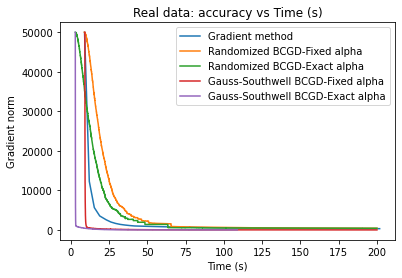

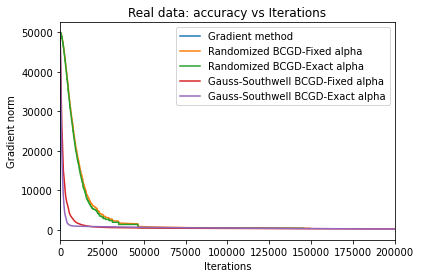

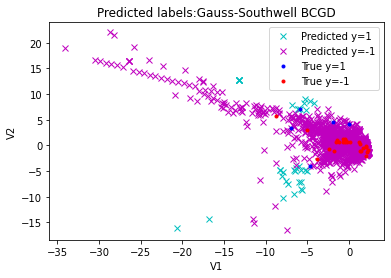

In [21]:
# Plotting the accuracy vs the time and the iterations
    
plot_accuracy('Time (s)', resultsDict=resultsRD, problem_type='Real data')
plot_accuracy('Iterations', resultsDict=resultsRD, problem_type='Real data')

#------------------------------------------------------------
# (Secondary) Assessing the accuracy of the prediction using the best mehtod in this case (GS-BCGD)
plot_classesRD(X_l=XLabeledRD, y_l=yLabeledRD, X_u=XUnlabeledRD, y_u=yPredBCGD_GS_ex_RD, method=stringBCGD_GS)

# Accuracy testing (with respect to the true data)
precision, recall, _ = precision_recall_curve(yTrueRD, yPredBCGD_GS_ex_RD)

# Area under the curve
pr_auc = auc(recall, precision)
print('Area under the precision-recall curve: Gauss-Southwell BCGD', pr_auc)

In [19]:
# Saving the results to avoid running everything again
import pandas as pd
import os

def save_results(resultsDict, title):
    for method, result in resultsDict.items():
        timeList = result[0]
        iterationsList = result[1]
        gradientNormList = result[2]
        methodTagList = [method]*len(result[0])
        df = pd.DataFrame({method:methodTagList, 'Time':timeList, 'Iterations':iterationsList, 'Gradient norm':gradientNormList})

        # Get the directory path of the current Jupyter notebook
        df.to_csv(f'./Temporary output/{title}-{method}.csv', index=False)
        np.savetxt(f'./Temporary output/{title}-Y_pred {method}.csv', result[2], delimiter=',')
        
save_results(resultsDict=resultsSD, title='SD')
save_results(resultsDict=resultsRD, title='RD')